Output()

ERROR:pymc.stats.convergence:There were 82 divergences after tuning. Increase `target_accept` or reparameterize.
/tmp/ipython-input-397896070.py:79: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


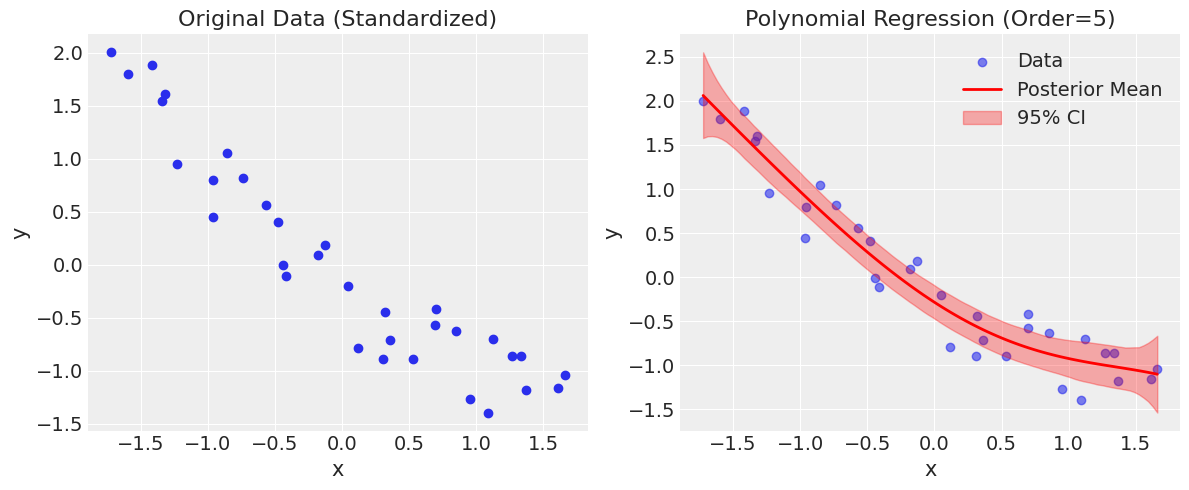

ERROR:pymc.stats.convergence:There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
/tmp/ipython-input-397896070.py:121: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


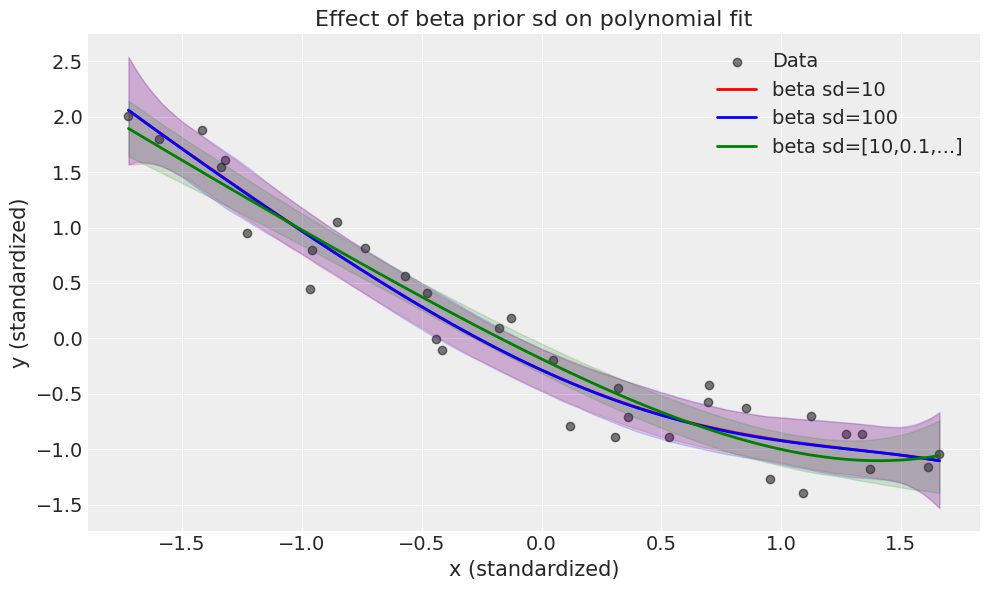

Summary for beta sd=10:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha    0.001  0.051  -0.096    0.092      0.001    0.001    2629.0   
beta[0] -1.443  0.250  -1.887   -0.975      0.008    0.004     929.0   
beta[1]  0.240  0.668  -1.075    1.460      0.014    0.014    2289.0   
beta[2]  0.351  2.660  -4.328    5.622      0.110    0.051     585.0   
beta[3]  0.325  4.440  -8.350    8.359      0.172    0.085     668.0   
beta[4] -0.369  2.270  -4.629    3.846      0.080    0.042     795.0   
epsilon  0.285  0.040   0.215    0.357      0.001    0.001    1746.0   

         ess_tail  r_hat  
alpha      2087.0   1.00  
beta[0]    1661.0   1.01  
beta[1]    1714.0   1.00  
beta[2]    1132.0   1.01  
beta[3]    1220.0   1.01  
beta[4]    1439.0   1.01  
epsilon    1770.0   1.00  

Summary for beta sd=100:
          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha   -0.001  0.051  -0.099    0.096      0.001    0.001    2521.0   
beta[0] -1.43

In [ ]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
az.style.use('arviz-darkgrid')

dummy_data = np.loadtxt('./date.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 5

# Create polynomial features
x_1p = np.vstack([x_1**i for i in range(1, order+1)])

# Standardize features
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)

# Standardize target
y_1s = (y_1 - y_1.mean()) / y_1.std()

# Build the model
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=order)
    epsilon = pm.HalfCauchy('epsilon', beta=5)

    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=y_1s)

    trace_p = pm.sample(2000, tune=1000, return_inferencedata=True)

# Plot original data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Original Data (Standardized)')

# a) Perform inference and plot the curve
plt.subplot(1, 2, 2)
plt.scatter(x_1s[0], y_1s, alpha=0.6, label='Data')

# Generate predictions for plotting
x_range = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

# We need to transform x_range back to original scale, create polynomial features, then standardize
x_range_original = x_range * x_1p.std(axis=1, keepdims=True)[0] + x_1p.mean(axis=1, keepdims=True)[0]
x_range_poly = np.vstack([x_range_original**i for i in range(1, order+1)])
x_range_std = (x_range_poly - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)

# Get posterior samples
alpha_post = trace_p.posterior['alpha'].values.flatten()
beta_post = trace_p.posterior['beta'].values.reshape(-1, order)

# Calculate predictions for each posterior sample
y_pred_samples = []
for i in range(len(alpha_post)):
    y_pred_i = alpha_post[i] + np.dot(beta_post[i], x_range_std)
    y_pred_samples.append(y_pred_i)

y_pred_samples = np.array(y_pred_samples)

# Plot mean prediction
y_pred_mean = y_pred_samples.mean(axis=0)
plt.plot(x_range, y_pred_mean, 'r-', linewidth=2, label='Posterior Mean')

# Plot credible interval
y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=0)
y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=0)
plt.fill_between(x_range, y_pred_lower, y_pred_upper, alpha=0.3, color='red', label='95% CI')

plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Polynomial Regression (Order={order})')
plt.legend()
plt.tight_layout()
plt.show()

# b)
# Helper function to run model and return posterior predictive mean and CI
def run_poly_model(beta_sd, label, color):
    with pm.Model() as model:
        alpha = pm.Normal('alpha', mu=0, sigma=10)
        beta = pm.Normal('beta', mu=0, sigma=beta_sd, shape=order)
        epsilon = pm.HalfCauchy('epsilon', beta=5)
        mu = alpha + pm.math.dot(beta, x_1s)
        y_pred = pm.Normal('y_pred', mu=mu, sigma=epsilon, observed=y_1s)
        trace = pm.sample(2000, tune=1000, return_inferencedata=True, progressbar=False)
    alpha_post = trace.posterior['alpha'].values.flatten()
    beta_post = trace.posterior['beta'].values.reshape(-1, order)
    y_pred_samples = []
    for i in range(len(alpha_post)):
        y_pred_i = alpha_post[i] + np.dot(beta_post[i], x_range_std)
        y_pred_samples.append(y_pred_i)
    y_pred_samples = np.array(y_pred_samples)
    y_pred_mean = y_pred_samples.mean(axis=0)
    y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=0)
    y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=0)
    plt.plot(x_range, y_pred_mean, color=color, linewidth=2, label=label)
    plt.fill_between(x_range, y_pred_lower, y_pred_upper, alpha=0.15, color=color)
    return trace

# Plot all curves for comparison
plt.figure(figsize=(10, 6))
plt.scatter(x_1s[0], y_1s, alpha=0.5, label='Data', color='k')

# Original (sd=10)
'''The prior is moderately wide, allowing the coefficients to vary but not too much.
The resulting curve fits the data well but avoids extreme oscillations.
The credible interval is reasonable, reflecting moderate uncertainty.'''
trace_10 = run_poly_model(10, 'beta sd=10', 'red')
# sd=100
'''
The prior is extremely wide, allowing the coefficients to take very large values.
The resulting curve can become much more flexible, possibly overfitting the data, especially at the edges.
The credible interval is much wider, reflecting much greater uncertainty in the fit, especially where data is sparse.
'''
trace_100 = run_poly_model(100, 'beta sd=100', 'blue')
# sd=[10,0.1,0.1,0.1,0.1]
trace_vec = run_poly_model(np.array([10,0.1,0.1,0.1,0.1]), 'beta sd=[10,0.1,...]', 'green')

plt.xlabel('x (standardized)')
plt.ylabel('y (standardized)')
plt.title('Effect of beta prior sd on polynomial fit')
plt.legend()
plt.tight_layout()
plt.show()

print('Summary for beta sd=10:')
print(az.summary(trace_10))
print('\nSummary for beta sd=100:')
print(az.summary(trace_100))
print('\nSummary for beta sd=[10,0.1,0.1,0.1,0.1]:')
print(az.summary(trace_vec))
